In [1]:
import os
GPU_id = 2
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
import seaborn as sns
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from termcolor import colored
from cudf_workaround import cudf_groupby_aggs
import matplotlib.pyplot as plt
import time

sns.set()
print(gd.__version__)

0.8.0+0.g8fa7bd3.dirty


**This is a 2 minutes end-to-end gpu-only demos the 8th place solution (8/1094) of Rapids.ai for the __[PLAsTiCC Astronomical Classification](https://www.kaggle.com/c/PLAsTiCC-2018/leaderboard)__.** 

## Table of contents
[1. Global variables](#global)<br>
[2. Functions](#func)<br>
[3. ETL & Visualizations](#etl)<br>
[4. Model training](#train)<br>
[5. Conclusions](#conclusions)

<a id="global"></a>
## 1. Global variables 

**Original data download and description __[link](https://www.kaggle.com/c/PLAsTiCC-2018/data)__**.

In [3]:
#PATH = '../data'
#PATH = '/raid/data/ml/lsst/input'
PATH = '../input'

**Tested on V100 with 32 GB GPU memory. Please reset this variable if memory capacity is smaller, and the input data will be down sampled accordingly.**

In [4]:
GPU_MEMORY = 32 # GB. 
#GPU_MEMORY = 16 # GB. Both 32 and 16 GB have been tested

In [5]:
TEST_ROWS = 453653104 # number of rows in test data
# no skip if your gpu has 32 GB memory
# otherwise, skip rows porportionally
OVERHEAD = 1.4 # cudf 0.7 introduces 20% memory overhead comparing to cudf 0.4
SKIP_ROWS = int((1 - GPU_MEMORY/(32.0*OVERHEAD))*TEST_ROWS) 
GPU_RUN_TIME = {}

<a id="func"></a>
## 2. Functions

In [6]:
def scatter(x,y,values,xlabel='x',ylabel='y',title=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    colors = np.array([colors[i] for i in values])
    ps = []
    bs = []
    bands = ['passband_%s'%i for i in ['u', 'g', 'r', 'i', 'z','y']]
    for i in sorted(np.unique(values)):
        mask = values==i
        if len(x[mask]):
            p = plt.scatter(x[mask],y[mask],c=colors[mask])
            ps.append(p)
            bs.append(bands[i])
    plt.legend(ps,bs,scatterpoints=1)
    if title is not None:
        plt.title(title)
    
    plt.xlim([np.min(x)-10,np.min(x)+1500])
    plt.ylabel('y: %s'%ylabel)
    plt.xlabel('x: %s'%xlabel)

In [7]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    """
    refactor from
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true, classes, class_weights):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted, 
                                  classes, class_weights)
    return 'wloss', loss

### GPU ETL functions 

In [8]:
# To save GPU memory, we drop the column as soon as it is done with groupby
# this hits performance a little but avoids GPU OOM.
def groupby_aggs(df,aggs,col):
    res = None
    for i,j in aggs.items():
        for k in j:
            #print(i,k)
            tmp = df.groupby(col,as_index=False).agg({i:[k]})
            tmp.columns = [col,'%s_%s'%(k,i)]
            #print(tmp.columns)
            if res is None:
                res = tmp
            else:
                res = res.merge(tmp,on=[col],how='left')
        df.drop_column(i)
    return res

def etl_gpu(df,df_meta):
    aggs = {
        'passband': ['mean'], 
        'detected': ['mean'],
        'mjd':['max','min'],
    }
    agg_df = groupby_aggs(df,aggs,'object_id')
    # at this step, columns ['passband','detected','mjd'] are deleted 
    
    df['flux_ratio_sq'] = df['flux'] / df['flux_err']
    df['flux_ratio_sq'] = df['flux_ratio_sq'].applymap(lambda x: math.pow(x,2))
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs2 = {
        'flux_ratio_sq':['sum'],
        'flux_by_flux_ratio_sq':['sum'],
        'flux': ['min', 'max', 'mean'],
        'flux_err': ['min', 'max', 'mean'],
    }
    agg_df2 = groupby_aggs(df,aggs2,'object_id')
    agg_df = agg_df.merge(agg_df2,on=['object_id'],how='left')
    del agg_df2
    #print(agg_df.columns)

    agg_df['flux_diff'] = agg_df['max_flux'] - agg_df['min_flux']
    agg_df['flux_dif2'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['mean_flux']
    agg_df['flux_w_mean'] = agg_df['sum_flux_by_flux_ratio_sq'] / agg_df['sum_flux_ratio_sq']
    agg_df['flux_dif3'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['max_mjd'] - agg_df['min_mjd']
    agg_df.drop_column('max_mjd')
    agg_df.drop_column('min_mjd')
    
    for col in ['ra','decl','gal_l','gal_b']:
        df_meta.drop_column(col)
    
    df_meta = df_meta.merge(agg_df,on=['object_id'],how='left')
    return df_meta

<a id="etl"></a>
## 3. ETL & Visualizations

### Load data for ETL part 1
**GPU load data**

In [9]:
%%time
start = time.time()
step = 'load data part1'
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 15.2 s, sys: 5.6 s, total: 20.8 s
Wall time: 20.8 s


### Visualizations

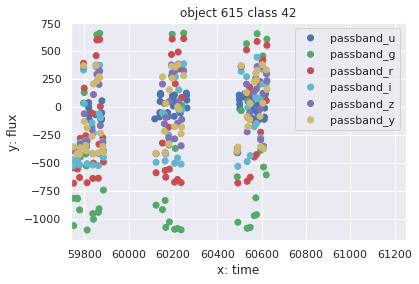

In [10]:
oid = 615
train = train_gd.to_pandas()
mask = train.object_id== oid
scatter(train.loc[mask,'mjd'].values,
                train.loc[mask,'flux'].values,
                values=train.loc[mask,'passband'].values,
                xlabel='time',ylabel='flux',title='object %d class 42'%oid)

### ETL part 1 with 100x  speedup

In [11]:
%%time
# to save memory, we need to move dataframe to cpu and only keep the columns we need
test_gd = test_gd[['object_id','flux']]
train_gd = train_gd[['object_id','flux']]

CPU times: user 8 ms, sys: 12 ms, total: 20 ms
Wall time: 19.8 ms


In [12]:
%%time
# GPU
step = 'ETL part1'
start = time.time()
aggs = {'flux':['skew']}
test_gd = cudf_groupby_aggs(test_gd,group_id_col='object_id',aggs=aggs)
train_gd = cudf_groupby_aggs(train_gd,group_id_col='object_id',aggs=aggs)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 11.2 s, sys: 1.13 s, total: 12.3 s
Wall time: 4.57 s


In [13]:
%%time
test_flux_skew_gd = test_gd.sort_values(by='object_id')
train_flux_skew_gd = train_gd.sort_values(by='object_id')

CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 35 ms


### Load data for the ETL part 2 with 11x speedup

In [14]:
%%time
# read data on gpu
step = 'load data part2'
start = time.time()
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)

cols = ['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 
       'distmod','mwebv', 'target']
dtypes = ['int32']+['float32']*4+['int32']+['float32']*5+['int32']

train_meta_gd = gd.read_csv('%s/training_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
del cols[-1],dtypes[-1]
test_meta_gd = gd.read_csv('%s/test_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 16.7 s, sys: 7.31 s, total: 24 s
Wall time: 23.9 s


### ETL part2 with 20x speedup 

In [15]:
%%time
# GPU
start = time.time()
step = 'ETL part2'
train_final_gd = etl_gpu(train_gd,train_meta_gd)
train_final_gd = train_final_gd.merge(train_flux_skew_gd,on=['object_id'],how='left')
test_final_gd = etl_gpu(test_gd,test_meta_gd)
del test_gd,test_meta_gd
test_final_gd = test_final_gd.merge(test_flux_skew_gd,on=['object_id'],how='left')
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 1.52 s, sys: 1.31 s, total: 2.83 s
Wall time: 4.29 s


### Merge bottleneck features

In [16]:
%%time
start = time.time()
step = 'Merge bottleneck'
train_bn = gd.from_pandas(pd.read_pickle('train_bn.pkl'))
train_bn['object_id'] = train_bn['object_id'].astype('int32')
train_final_gd = train_final_gd.merge(train_bn,on=['object_id'],how='left')
test_bn = gd.from_pandas(pd.read_pickle('test_bn.pkl'))
test_bn['object_id'] = test_bn['object_id'].astype('int32')
test_final_gd = test_final_gd.merge(test_bn,on=['object_id'],how='left')
del train_bn,test_bn
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 4.68 s, sys: 696 ms, total: 5.37 s
Wall time: 864 ms


In [17]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,bottleneck6,bottleneck7,bottleneck8,bottleneck9,bottleneck10,bottleneck11,bottleneck12,bottleneck13,bottleneck14,bottleneck15
0,39420562,0,0.1400,0.1440,0.1291,39.169300,0.125,15,3.161074,0.020134,...,1.468260,7.576409,8.293226,1.879001,7.890970,1.332858,5.112309,3.297430,5.024964,10.317993
1,39446441,0,0.3628,0.4729,0.0922,42.116398,0.058,15,3.264000,0.048000,...,3.096899,11.122345,11.219644,0.311516,5.098413,1.574663,5.603318,0.539439,4.548589,8.742877
2,39488530,0,0.2935,1.4029,0.4197,45.009701,0.052,15,2.967742,0.016129,...,2.294354,7.085364,9.345343,0.254227,4.393796,0.933247,4.269488,0.310794,4.531473,4.948568
3,39501380,0,0.2130,0.2166,0.0082,40.150097,0.105,52,2.933884,0.049587,...,7.761690,1.321868,6.200109,5.247349,2.655985,10.224785,3.501491,2.755973,19.987171,2.101240
4,39511222,0,0.0000,0.0000,0.0000,NaN,0.011,6,2.992481,0.105263,...,3.591951,5.538801,6.747207,0.311666,3.058628,1.451684,10.459455,4.461523,6.548873,6.281868


<a id="train"></a>
## 4. Model training

### train and validation with 5x speedup

In [18]:
y = train_final_gd['target'].to_array()
classes = sorted(np.unique(y))    
# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})

lbl = LabelEncoder()
y = lbl.fit_transform(y)

cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')
    
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y)

In [19]:
cpu_params = {
            'objective': 'multi:softprob', 
            'tree_method': 'hist', 
            'nthread': 16, 
            'num_class':14,
            'max_depth': 7, 
            'silent':1,
            'subsample':0.7,
            'colsample_bytree': 0.7,}

In [20]:
func_loss = partial(xgb_multi_weighted_logloss, 
                        classes=classes, 
                        class_weights=class_weights)

In [21]:
# GPU
gpu_params = cpu_params.copy()
gpu_params.update({'objective': 'multi:softprob',
                   'tree_method': 'gpu_hist', 
                  })

In [22]:
%%time
step = 'training'
start = time.time()
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(gpu_params, dtrain=dtrain,
                num_boost_round=60,evals=watchlist,
                feval=func_loss,early_stopping_rounds=10,
                verbose_eval=1000)
yp = clf.predict(dvalid)
gpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)
ysub = clf.predict(dtest)
line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))
GPU_RUN_TIME[step] = time.time() - start

[0]	eval-merror:0.259873	train-merror:0.192411	eval-wloss:1.76873	train-wloss:1.64557
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.182166	train-merror:0	eval-wloss:0.939263	train-wloss:0.027632
validation loss 0.9393
CPU times: user 56.6 s, sys: 5 s, total: 1min 1s
Wall time: 5.63 s


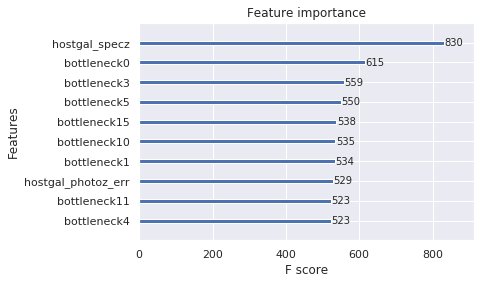

In [23]:
clf.feature_names=cols
xgb.plot_importance(clf,max_num_features=10)

<a id="conclusions"></a>
## 5. Conclustions

In [24]:
GPU_RUN_TIME

{'load data part1': 20.765159845352173,
 'ETL part1': 4.573681592941284,
 'load data part2': 23.908183813095093,
 'ETL part2': 4.286347389221191,
 'Merge bottleneck': 0.8638396263122559,
 'training': 5.626025438308716}

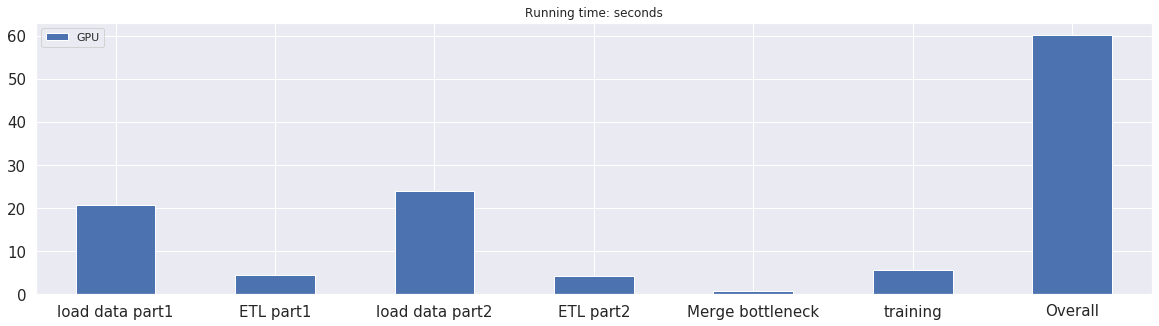

In [25]:
steps = ['load data part1','ETL part1','load data part2','ETL part2','Merge bottleneck','training']
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in steps])
steps.append('Overall')
gpu_time = [GPU_RUN_TIME[i] for i in steps]
df = pd.DataFrame({'GPU': gpu_time}, index=steps)
df.plot.bar(rot=0,figsize=(20,5), fontsize=15, title='Running time: seconds')